## Random Search for Hyperparameters


https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-optimization

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import (
    RandomizedSearchCV,
    train_test_split,
)

In [2]:
# if you want more information about the dataset for this demo:

# scikit-learn dataset
# https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-dataset

# dataset information: UCI Machine Learning Repository
# https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)
    
# in short, classification problem, trying to predict whether the tumor
# is malignant or benign

# load dataset
X, y = load_breast_cancer(return_X_y=True, as_frame=True)
y = y.map({0:1, 1:0})

X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
# percentage of benign (0) and malign tumors (1)

y.value_counts() / len(y)

target
0    0.627417
1    0.372583
Name: count, dtype: float64

In [4]:
# split dataset into a train and test set

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((398, 30), (171, 30))

In [5]:
stats.randint.rvs(1, 5)

3

In [6]:
stats.uniform.rvs(0, 1)

0.34796026607905683

## Random Search

Let's use Grid Search to find the best hyperparameters for a Gradient Boosting Classifier.

In [7]:
# set up the model
gbm = GradientBoostingClassifier(random_state=0)

# determine the hyperparameter space
param_grid = dict(
    n_estimators=stats.randint(10, 120),
    min_samples_split=stats.uniform(0, 1),
    max_depth=stats.randint(1, 5),
    loss=('log_loss', 'exponential'),
    )

In [8]:
# set up the search
search = RandomizedSearchCV(gbm,
                            param_grid,
                            scoring='roc_auc',
                            cv=5,
                            n_iter = 60,
                            random_state=10,
                            n_jobs=4,
                            refit=True)

# find best hyperparameters
search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=0),
                   n_iter=60, n_jobs=4,
                   param_distributions={'loss': ('log_loss', 'exponential'),
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002AB0C7B7EB0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002AB0C7B61A0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002AB0C7B53F0>},
                   random_state=10, scoring='roc_auc')

In [9]:
# the best hyperparameters are stored in an attribute

search.best_params_

{'loss': 'exponential',
 'max_depth': 3,
 'min_samples_split': 0.5345579488018151,
 'n_estimators': 99}

In [10]:
# we also find the data for all models evaluated

results = pd.DataFrame(search.cv_results_)

print(results.shape)

results.head()

(60, 17)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_loss,param_max_depth,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.425956,0.012599,0.008795,0.002784,exponential,2,0.020752,74,"{'loss': 'exponential', 'max_depth': 2, 'min_s...",1.000000,0.983333,0.989333,0.999310,0.991837,0.992763,0.006273,2
1,0.422356,0.039121,0.008198,0.002639,exponential,4,0.831911,103,"{'loss': 'exponential', 'max_depth': 4, 'min_s...",1.000000,0.973000,0.988000,0.998621,0.987075,0.989339,0.009733,25
2,0.104140,0.002481,0.007196,0.002398,log_loss,2,0.198063,18,"{'loss': 'log_loss', 'max_depth': 2, 'min_samp...",0.994667,0.965667,0.974333,0.987931,0.978912,0.980302,0.010162,51
3,0.159508,0.004174,0.006197,0.000401,exponential,1,0.263603,46,"{'loss': 'exponential', 'max_depth': 1, 'min_s...",0.998333,0.957667,0.983000,0.991724,0.979592,0.982063,0.013858,50
4,0.077154,0.002784,0.005997,0.000633,exponential,1,0.816602,21,"{'loss': 'exponential', 'max_depth': 1, 'min_s...",0.994000,0.948333,0.967333,0.986207,0.969048,0.972984,0.015947,55


In [11]:
# we can order the different models based on their performance
results.sort_values(by='mean_test_score', ascending=False, inplace=True)

results.reset_index(drop=True, inplace=True)

results[[
    'param_max_depth', 'param_min_samples_split', 'param_n_estimators',
    'mean_test_score', 'std_test_score',
]].head()

,param_max_depth,param_min_samples_split,param_n_estimators,mean_test_score,std_test_score
0,3,0.534558,99,0.993171,0.006967
1,2,0.020752,74,0.992763,0.006273
2,4,0.565507,92,0.992689,0.006204
3,2,0.043097,115,0.992613,0.005790
4,2,0.305460,92,0.992567,0.007091


In [12]:
results[[
    'param_max_depth', 'param_min_samples_split', 'param_n_estimators',
    'mean_test_score', 'std_test_score',
]].tail()

,param_max_depth,param_min_samples_split,param_n_estimators,mean_test_score,std_test_score
55,4,0.781949,18,0.972361,0.015814
56,2,0.821106,21,0.971264,0.011818
57,1,0.653623,14,0.969349,0.011463
58,1,0.104620,10,0.964248,0.016026
59,2,0.820704,10,0.964244,0.015191


Text(0.5, 0, 'Hyperparameter combinations')

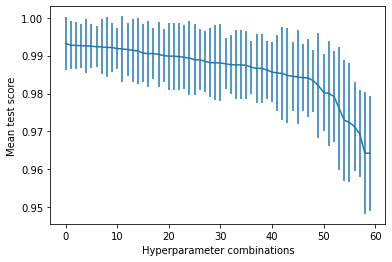

In [13]:
# plot model performance and error

results['mean_test_score'].plot(yerr=[results['std_test_score'], results['std_test_score']], subplots=True)

plt.ylabel('Mean test score')
plt.xlabel('Hyperparameter combinations')

In [14]:
X_train_preds = search.predict_proba(X_train)[:,1]
X_test_preds = search.predict_proba(X_test)[:,1]

print('Train roc_auc: ', roc_auc_score(y_train, X_train_preds))
print('Test roc_auc: ', roc_auc_score(y_test, X_test_preds))

Train roc_auc:  1.0
Test roc_auc:  0.9988242210464433


In [15]:
# let's make a function to evaluate the model performance based on
# single hyperparameters

def summarize_by_param(hparam):
    
    tmp = pd.concat([
        results.groupby(hparam)['mean_test_score'].mean(),
        results.groupby(hparam)['mean_test_score'].std(),
    ], axis=1)

    tmp.columns = ['mean_test_score', 'std_test_score']
    
    return tmp

In [16]:
# performance change for n_estimators

tmp = summarize_by_param('param_n_estimators')

tmp.head()

,mean_test_score,std_test_score
param_n_estimators,,
10,0.964246,0.000003
14,0.969349,NaN
16,0.979216,NaN
17,0.984554,NaN
18,0.976331,0.005615


Text(0, 0.5, 'roc-auc')

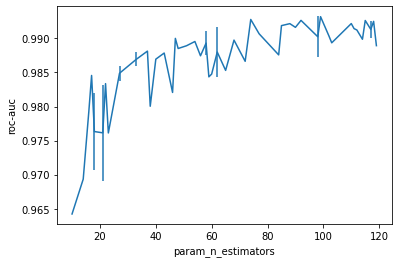

In [17]:
tmp['mean_test_score'].plot(yerr=[tmp['std_test_score'], tmp['std_test_score']], subplots=True)
plt.ylabel('roc-auc')

The optimal hyperparameter seems to be somewhere between 60 and 100.

Text(0, 0.5, 'roc-auc')

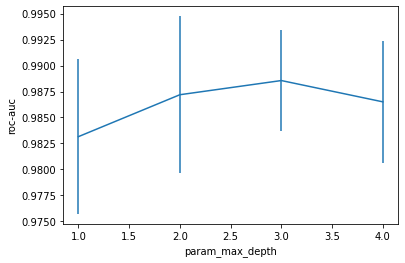

In [18]:
tmp = summarize_by_param('param_max_depth')
tmp['mean_test_score'].plot(yerr=[tmp['std_test_score'], tmp['std_test_score']], subplots=True)
plt.ylabel('roc-auc')

The optimal hyperparameter seems to be between 2 and 3.

array([<Axes: xlabel='param_min_samples_split'>], dtype=object)

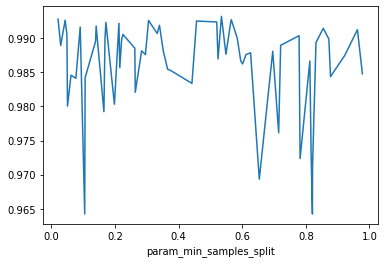

In [19]:
tmp = summarize_by_param('param_min_samples_split')
tmp['mean_test_score'].plot(yerr=[tmp['std_test_score'], tmp['std_test_score']], subplots=True)

This parameter does not seem to improve performance much.

(0.97, 1.0)

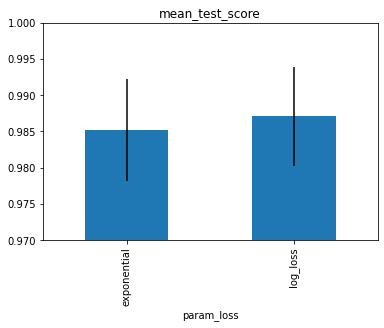

In [20]:
tmp = summarize_by_param('param_loss')
tmp['mean_test_score'].plot.bar(yerr=[tmp['std_test_score'], tmp['std_test_score']], subplots=True)
plt.ylim(0.97,1)